In [73]:
import os
from typing import List
import numpy as np
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm,iqr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import math

from sklearn.decomposition import PCA
import scipy

class Point():
    def __init__(self, x: int, y: int, *, theta=None):
        self.x = int(x)
        self.y = int(y)
        self.theta = round(theta, 1) if theta else None
        
    def __repr__(self):
        if self.theta:
            return f"Point(x={self.x}, y={self.y}, theta={self.theta})"
        
        return f"Point(x={self.x}, y={self.y})"
    
    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)
    
    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)
    
    def set_theta(self, front, back):
        self.theta= round(np.rad2deg( np.arctan2(front.y - back.y, front.x - back.x)) - 90.0, 1)

    @classmethod
    def from_encoder(cls, x: float, y: float, theta:float):
        
        x_mm = int(float(x) * 10)
        y_mm = int(float(y) * 10)
        theta = round(float(theta.strip()), 1)
        
        return Point(x_mm, y_mm, theta=theta)
        
        
        
        
start = Point(-56, -67)
front_marker = Point(0, 69)
back_marker = Point(0, -168)


dir_data = "/".join(os.path.abspath('').split("/")[:-2]) + "/data/Assignment_1_2/"
assert os.path.isdir(dir_data), "Could not find the data directory"

path_encoded_forward = dir_data + "forward_logs"
path_encoded_left = dir_data + "left_logs"
path_encoded_right = dir_data + "right_logs"

path_measurements_forward = dir_data + "measurements/pain_forward.csv"
path_measurements_left= dir_data + "measurements/pain_left.csv"
path_measurements_right = dir_data + "measurements/pain_right.csv"

assert all(os.path.isdir(path) for path in [path_encoded_forward, path_encoded_left, path_encoded_right])
assert all(os.path.isfile(path) for path in [path_measurements_forward, path_measurements_left, path_measurements_right])


export_folder = os.path.join(dir_data, "export")

if not os.path.exists(export_folder):
    os.makedirs(export_folder)


In [56]:
def measured_to_pose(measurements: List[List[int]]) -> List[Point]:
    poses = []
    for measurement in measurements:
        if not measurement:
            continue
            
        front = Point(measurement[0], measurement[1])
        back = Point(measurement[2], measurement[3])
        
        front = front + start
        back = back + start
        
        real_x = (front.x - front_marker.x + back.x - back_marker.x ) / 2
        real_y = (front.y - front_marker.y + back.y - back_marker.y ) / 2
        
        pose = Point(real_x, real_y)
        pose.set_theta(front, back)
        
        poses.append(pose)
        
    return poses
        
        

def load_measurement(path: str) -> List[List[int]]:
    with open(path, 'r') as f:
        reader = csv.reader(f)
        print(f"Read file: '{path}'")
        print("Headers: ", next(reader))
        
        return [row for row in reader]
    
def load_last_encoder_measurement(dir_path: str) -> List[Point]:
    end_poses = []
    
    files = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
    header = None
    
    for path in files:  
        with open (path, "r") as f:
            reader = csv.reader(f)
            if not header:
                header = next(reader)

            all_data = list(reader) 
            end_poses.append(Point.from_encoder(* all_data[-1][:3]))
            
                
    print(f"Read {len(files)} files from '{dir_path}'")
    print(f"Headers: {header}")
            
    return end_poses


    
transformed_forward = measured_to_pose(load_measurement(path_measurements_forward))
transformed_left = measured_to_pose(load_measurement(path_measurements_left))
transformed_right = measured_to_pose(load_measurement(path_measurements_right))

encoded_forward = load_last_encoder_measurement(path_encoded_forward)
encoded_left = load_last_encoder_measurement(path_encoded_left)
encoded_right = load_last_encoder_measurement(path_encoded_right)



# print("\nforward")
# for p, e in zip(transformed_forward, encoded_forward):
#     print(p, e)
    
# print("\nleft")
# for p, e in zip(transformed_left, encoded_left):
#     print(p, e)    

# print("\nright")
# for p, e in zip(transformed_right, encoded_right):
#     print(p, e)
    


Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_forward.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_left.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read file: '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/measurements/pain_right.csv'
Headers:  ['x_front', ' y_front', ' x_back', ' y_back']
Read 42 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/forward_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']
Read 40 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/left_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']
Read 42 files from '/home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/right_logs'
Headers: ['robot_position_x', ' robot_position_y', ' robot_orientation']


In [51]:
import math

encoded_forward_bad_ones = [e for e in encoded_forward if e.theta > 999]
encoded_forward_good_ones = [e for e in encoded_forward if e.theta < 900]

encoded_left_bad_ones = [e for e in encoded_left if e.theta > 999]
encoded_left_good_ones = [e for e in encoded_left if e.theta < 900]

encoded_right_bad_ones = [e for e in encoded_right if e.theta > 999]
encoded_right_good_ones = [e for e in encoded_right if e.theta < 900]

def get_mean(data: List[Point]):
    size = len(data)
    
    mean_x = float(sum([p.x for p in data])) / size
    mean_y = float(sum([p.y for p in data])) / size
    mean_theta = float(sum([p.theta for p in data])) / size
    
    return mean_x, mean_y, mean_theta 

def std_err(data: List[Point]): 
    size = len(data)
    mean_x, mean_y, mean_theta = get_mean(data)
    
    var_x = math.sqrt(float(sum([(p.x - mean_x) ** 2 for p in data])) / size * (size -1))
    var_y = math.sqrt(float(sum([(p.y - mean_y) **2 for p in data])) / size * (size -1))
    var_theta = math.sqrt(float(sum([(p.theta - mean_theta) ** 2 for p in data])) / size * (size -1))
    
    return var_x, var_y, var_theta
    

print(get_mean(encoded_forward_bad_ones))
print(get_mean(encoded_left_bad_ones))

print(get_mean(encoded_right_bad_ones))

print("std forward bad", std_err(encoded_forward_bad_ones))
print("std forward good", std_err(encoded_forward_good_ones))
print("std reeal forward good", std_err(transformed_forward))

print()

print("std left bad", std_err(encoded_left_bad_ones))
print("std left good", std_err(encoded_left_good_ones))
print("std reeal left good", std_err(transformed_left))


print()

print("std forward bad", std_err(encoded_right_bad_ones))
print("std forward good", std_err(encoded_right_good_ones))
print("std reeal right good", std_err(transformed_right))


(166.28571428571428, 166.47619047619048, 1586564997.1)
(124.7, 166.5, 1586568533.69)
(167.04761904761904, 125.47619047619048, 1586567022.109524)
std forward bad (10.248610325573033, 10.01133144839459, 3356.2549708593865)
std forward good (4.8748510065027535, 28.45213189769458, 9.930136612989092e-16)
std reeal forward good (31.7811264746862, 28.453295064016757, 6.145892937564076)

std left bad (8.836854644046152, 11.977061409210524, 1238.1591510061626)
std left good (24.700000000000006, 16.908651631635205, 0.21794494717703386)
std reeal left good (23.930315501472187, 24.52243870417459, 5.519603699542204)

std forward bad (17.91387812503083, 12.544704640304277, 1394.1276083178914)
std forward good (37.79404745030277, 23.803808837930617, 0.0952380952380952)
std reeal right good (41.91064900475773, 28.955526242843533, 12.86907242189584)


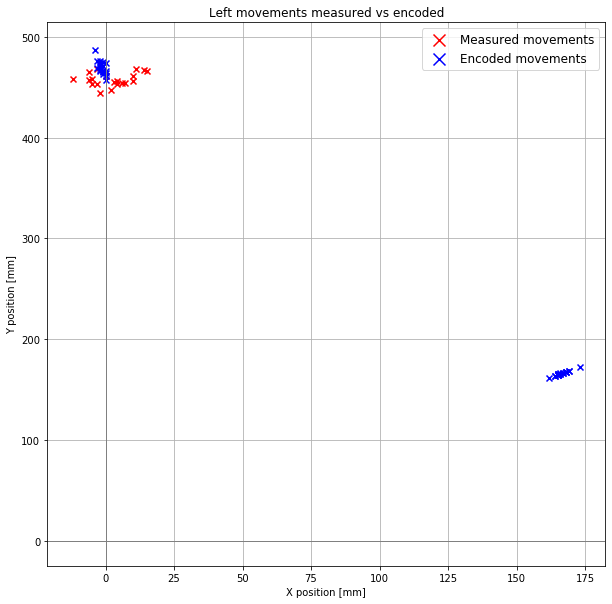

In [52]:
fig, ax_nstd = plt.subplots(figsize=(10, 10))
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

ax_nstd.scatter([p.x for p in transformed_forward], [p.y for p in transformed_forward], 
                color='r', label="Measured movements", marker='x')
ax_nstd.scatter([p.x for p in encoded_forward], [p.y for p in encoded_forward], 
                color='b', label="Encoded movements", marker='x')
ax_nstd.set_xlabel('X position [mm]')
ax_nstd.set_ylabel('Y position [mm]')
ax_nstd.set_title('Left movements measured vs encoded')
ax_nstd.legend(fontsize='large', markerscale=2.0)
ax_nstd.grid()
plt.show()

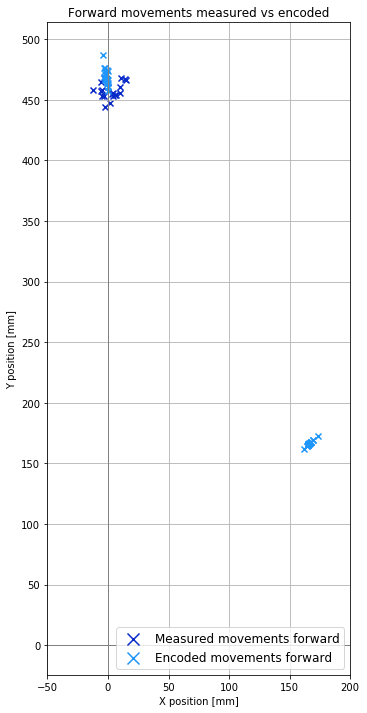

In [47]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.scatter([p.x for p in transformed_forward], [p.y for p in transformed_forward], 
                color='#072AC8', label="Measured movements forward", marker='x')
ax.scatter([p.x for p in encoded_forward], [p.y for p in encoded_forward], 
                color='#1E96FC', label="Encoded movements forward", marker='x', )

ax.set_xlabel('X position [mm]')
ax.set_ylabel('Y position [mm]')
ax.set_title('Forward movements measured vs encoded')
ax.legend(fontsize='large', markerscale=2.0, loc=4)
ax.grid()
ax.set_aspect('equal')
ax.set_yticks([i * 50 for i in range(11)])
ax.set_xbound(-50,200)
plt.show()

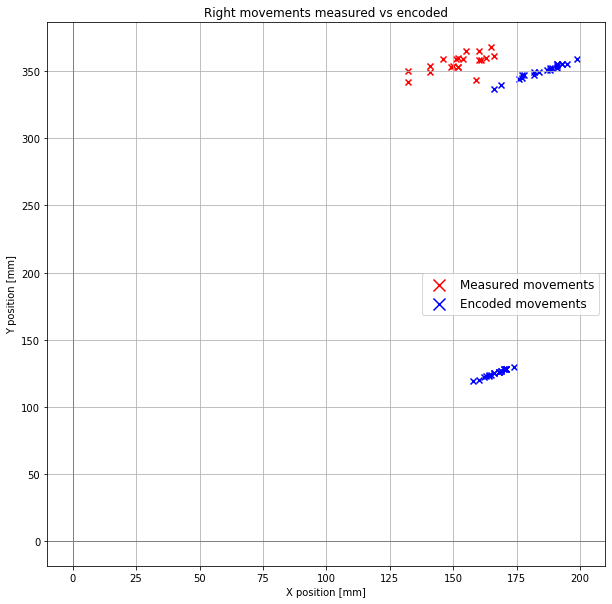

In [25]:
fig, ax_nstd = plt.subplots(figsize=(10, 10))
ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

ax_nstd.scatter([p.x for p in transformed_right], [p.y for p in transformed_right], 
                color='r', label="Measured movements", marker='x')
ax_nstd.scatter([p.x for p in encoded_right], [p.y for p in encoded_right], 
                color='b', label="Encoded movements", marker='x')
ax_nstd.set_xlabel('X position [mm]')
ax_nstd.set_ylabel('Y position [mm]')
ax_nstd.set_title('Right movements measured vs encoded')
ax_nstd.legend(fontsize='large', markerscale=2.0)
ax_nstd.grid()
plt.show()

Saving chart as /home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/export/ellipses_right_measured_vs_all_encoded
Saving chart as /home/sd/Documents/code/mas-ss-21/SEE/data/Assignment_1_2/export/ellipses_right_measured_vs_all_encoded_zoomed_in


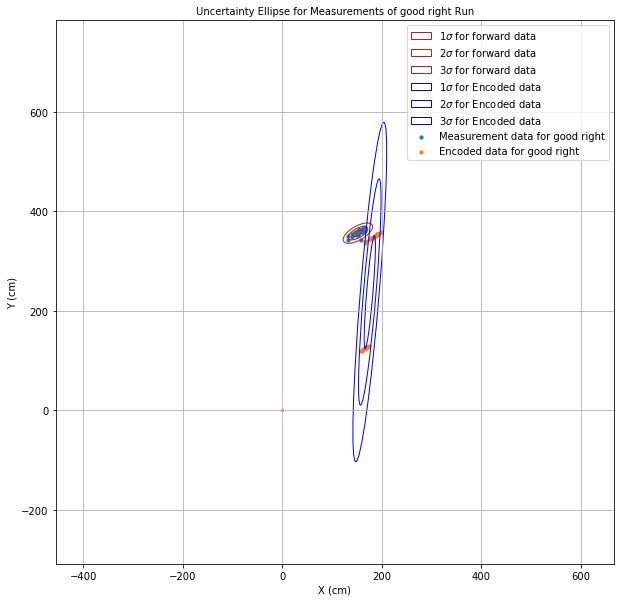

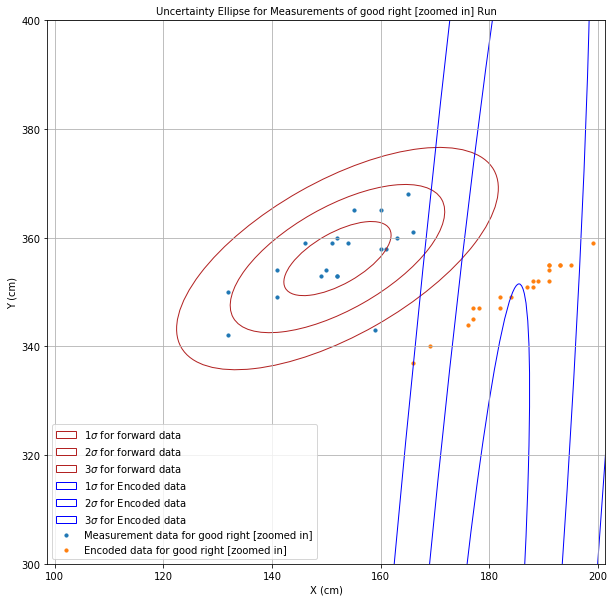

In [100]:
def plot_ellipse(x0, y0, *, x1=None, y1=None, title="Plot", filename=None, prefix_x1="Encoded", bounds=None):
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    
    def get_ellipses(x, y, ax, label, color='firebrick'):
        ellipses = []
        cov = np.cov(x, y)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        
        for i in range(1,4):
            w, h = 2 * i * np.sqrt(vals)
            ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                          width=w, height=h,
                          angle=theta, color=color, label=f'${i}\sigma$ for {label}')

            ellipses.append(ell)
            ell.set_facecolor('none')
            ax.add_patch(ell)
    
        return ellipses
    
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.margins(0.3, 0.3)
    
    # Scatter plot x and y
    plt.scatter(x0, y0, s=10, label = "Measurement data for " + title )
    
    if x1 and y1:
        plt.scatter(x1, y1, s=10, label = f"{prefix_x1} data for " + title)
        
    
    ellipses = get_ellipses(x0, y0, ax, "forward data")
    
    if x1 and y1:
        ellipses.extend(get_ellipses(x1, y1, ax, f"{prefix_x1} data", 'blue'))
        
    # Plot
    plt.title('Uncertainty Ellipse for Measurements of ' + title +' Run', fontsize= 10)
    plt.xlabel('X (cm)', fontsize= 10)
    plt.ylabel('Y (cm)', fontsize= 10)
    ax.scatter(0, 0, c='red', s=3)
    plt.legend()
    plt.grid()
#     ax.set_aspect('equal')
    plt.axis('equal')
    
    if bounds:
        ax.set_xbound(bounds["x_min"], bounds["x_max"])
        ax.set_ybound(bounds["y_min"], bounds["y_max"])
    

    if filename:
        print(f"Saving chart as {filename}")
        plt.savefig(filename, dpi=500, format='svg')
    

bounds = {
    "x_min": 100,
    "x_max": 200,
    "y_min": 300,
    "y_max": 400,
}
plot_ellipse(
    [p.x for p in transformed_right],
    [p.y for p in transformed_right], 
    title='good right',
    x1=[p.x for p in encoded_right],
    y1=[p.y for p in encoded_right],
    filename=os.path.join(export_folder, "ellipses_right_measured_vs_all_encoded"),
)

plot_ellipse(
    [p.x for p in transformed_right],
    [p.y for p in transformed_right], 
    title='good right [zoomed in]',
    x1=[p.x for p in encoded_right],
    y1=[p.y for p in encoded_right],
    filename=os.path.join(export_folder, "ellipses_right_measured_vs_all_encoded_zoomed_in"),
    bounds=bounds
)

